### This notebook contains skeleton code, and discusses some ideas on how to approach the problem of designing a robot control architecuture using BLE.

# A Robot Control Class
Classes provide a means of bundling data and functionality together. It helps organize your thoughts and your code. 

Below is the skeleton of one possible class structure to deal with robot communication. You do not have to use the exact same structure, it merely serves as a reference.

In [1]:
%load_ext autoreload
%autoreload 2

from ble import get_ble_controller
from base_ble import LOG
from cmd_types import CMD
import time
import numpy as np
import matplotlib.pyplot as plt

LOG.propagate = False

In [76]:
class RobotControl():
    # Initialize Function
    def __init__(self, ble):
        self.ble = ble
        
        # A variable to store the latest sensor value
        self.latest_tof_front_reading = None
        self.latest_tof_side_reading = None
        
        # A list to store the history of all the sensor values
        # Each item in the list is a tuple (value, time)
        # WARNING: The list could grow really fast; you need to deal with this accordingly.
        self.tof_readings = []
        self.tof2_readings = []
        
        self.imu_readings = []
        
        # A variable to store the latest imu reading
        self.latest_imu_reading = None
        
        # Activate notifications (if required)
        self.setup_notify()
    
    # A function to activate various notifications (if required)
    def setup_notify(self):
        # Code to setup various notify events
        # Ex:
        # ble.start_notify(ble.uuid['RX_TOF2'], self.tof_callback_handler)
        # ble.start_notify(ble.uuid['RX_FANCY_SENSOR'], self.fancy_sensor_callback_handler)
        self.ble.start_notify(self.ble.uuid['RX_TOF1'], self.tof_callback_handler)
        self.ble.start_notify(self.ble.uuid['RX_TOF2'], self.tof2_callback_handler)
        self.ble.start_notify(self.ble.uuid['RX_IMU'], self.imu_callback_handler)
    
    def stop_notify(self, sensor):
        self.ble.stop_notify(ble.uuid[f'RX_{sensor}'])
        
    # An example function callback handler for storing the history of the tof sensor
    # Your callback handlers should perform minimal processing!
    # Do not add a receive_* function inside the callback handler, it defeats the purpose of BLE notify
    def tof_callback_handler(self, uuid, byte_array):
        # Append a tuple (value, time) to a list
        self.tof_readings.append( ( self.ble.bytearray_to_float(byte_array), time.time() ) )
        self.update_tof_readings()
    
    def tof2_callback_handler(self, uuid, byte_array):
        # Append a tuple (value, time) to a list
        self.tof2_readings.append( ( self.ble.bytearray_to_float(byte_array), time.time() ) )
        self.update_tof2_readings()
    
    def imu_callback_handler(self, uuid, byte_array):
        self.imu_readings.append( ( self.ble.bytearray_to_float(byte_array), time.time() ) )
        self.update_imu_readings()
    
    def update_imu_readings(self):
        if len(self.imu_readings) > 10000:
            self.imu_readings = self.imu_readings[-10000:]
    
    def update_tof_readings(self):
        if len(self.tof_readings) > 10000:
            self.tof_readings = self.tof_readings[-10000:]
    
    def update_tof2_readings(self):
        if len(self.tof2_readings) > 10000:
            self.tof2_readings = self.tof2_readings[-10000:]
    
    # An example function to fetch the front TOF sensor reading
    # Here we assume RX_TOF1 is a valid UUID defined in connection.yaml and
    # in the Arduino code as well
    def get_front_tof(self):
        self.latest_tof_front_reading = self.ble.receive_float(self.ble.uuid['RX_TOF2'])
        print(self.latest_tof_front_reading)
    
    def get_side_tof(self):
        self.latest_tof_side_reading = self.ble.receive_float(self.ble.uuid['RX_TOF1'])
        print(self.latest_tof_side_reading)
    
    # An example function to fetch the IMU readings as a string
    # Here we assume RX_IMU is a valid UUID defined in connection.yaml and
    # in the Arduino code as well
    def get_imu(self):
        self.ble.send_command(CMD.GET_IMU, '')
        self.latest_imu_reading = self.ble.receive_float(self.ble.uuid['RX_IMU'])
        
        print(self.latest_imu_reading)
    
    # A function to instruct the robot to move forward
    def move_forward(self, speed, forward, doPID = 0):
        # Code to move forward
        # Ex: 
        # Here we assume the command is defined in cmd_types.py and 
        # the Artemis is programmed to handle it accordingly
        # ble.send_command(CMD.MOVE_FORWARD, speed)
        
        """
        speed: two element list ([motor1Speed, motor2Speed])
        time: duration of robot movement in seconds
        forward:
        doPID: 0 when PID should be done and 1 otherwise
        """
        self.tof_readings = []
        self.tof2_readings = []
        
        self.ble.send_command(CMD.MOVE_FORWARD, f'{speed[0]}|{speed[1]}|{forward}|{doPID}')
    
    # A function to stop robot motion
    def stop(self):
        # Code to stop robot motion
        self.ble.send_command(CMD.STOP_ROBOT, '')
    
    # A function to instruct the robot to update PID constants
    def updatePID(self, setpoint, k_p, k_i, k_d):
        self.ble.send_command(CMD.UPDATE_PID, f'{setpoint}|{k_p}|{k_i}|{k_d}')

### You can now use such a class to control your robot

In [217]:
# Get ArtemisBLEController object
ble = get_ble_controller()

# Connect to the Artemis Device
ble.connect()

# Instantiate RobotControl class
rc = RobotControl(ble)

2022-03-14 23:40:34,611 | INFO     |: Looking for Artemis Nano Peripheral Device: C0:83:B0:6C:9A:3C
2022-03-14 23:40:37,411 | INFO     |: Connected to C0:83:B0:6C:9A:3C


In [222]:
startingSpeed = 60
rc.updatePID(300, 0.15, 0.00005, 0.1)

In [223]:
rc.move_forward([startingSpeed, startingSpeed], 0)
time.sleep(7)
rc.stop()

In [227]:
rc.tof2_readings[0]

(633.0, 1647315708.596189)

In [225]:
file = 'trial60_15.txt'
with open(file, 'w') as f:
    for item in rc.tof2_readings:
        f.write(str(item))
        f.write("\n")

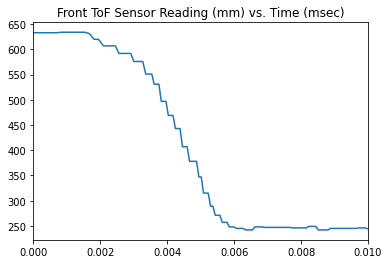

2022-03-14 23:48:05,837 | INFO     |: Disconnected from 607452C2-8441-D076-814E-841EB3635426


In [226]:
def plot(x):
    start_time = x[0][1]
    plt.plot([(x[i][1] - start_time) for i in range(len(x))], [x[i][0] for i in range(len(x))])
    plt.title('Front ToF Sensor Reading (mm) vs. Time (msec)')
    plt.xlim([0, 0.01])
plot(rc.tof2_readings)

In [210]:
rc.move_forward([50, 50], 1, 1) # 0 to go forwards and 1 not to do PID
time.sleep(3)
rc.stop()

In [287]:
def processRunData(file):
    with open(file, 'r') as f:
        x = f.read().splitlines()
    
    calculate = False
    comma = x[0].index(",")
    oldSensorValue = float(x[0][1:comma])
    oldTimeValue = float(x[0][comma+2:-1])

    for val in x[1:]:

        comma = val.index(",")
        newSensorValue = float(val[1:comma])
        newTimeValue = float(val[comma+2:-1])

        #print(newTimeValue-oldTimeValue)

        if (newTimeValue - oldTimeValue) > 0.5:
            timeDelta = newTimeValue - oldTimeValue
            sensorDelta = newSensorValue - oldSensorValue
            
            speed = sensorDelta/timeDelta
            if speed > 0:
                print(f'{speed} m/s')

            oldTimeValue = newTimeValue
            oldSensorValue = newSensorValue

In [290]:
files = ['trial60_15.txt', '300+2x.txt', '300+2x_2.txt', 'trial10.txt']

for file in files:
    print(file)
    processRunData(file)
    print("\n")

trial60_15.txt
3.925657516354551 m/s
7.849617910953344 m/s
1.9595321010137063 m/s
1.9035936462522483 m/s
13.732706383762922 m/s


300+2x.txt
7.618188241341387 m/s
5.871623198090157 m/s
9.51607223886015 m/s
5.716802965870679 m/s
3.805710511129581 m/s
3.922813895893035 m/s
1.9625109897796804 m/s
3.805415292323898 m/s
3.8104592887749043 m/s
3.9209583122217713 m/s
7.41238896139528 m/s


300+2x_2.txt
1.903402732460149 m/s
3.9214055452920364 m/s
7.201575852946719 m/s
1.9076759059894135 m/s
3.809559448298788 m/s


trial10.txt
13.73061272592161 m/s
1.9579249367128198 m/s
1.8022986451082568 m/s
5.71126306353331 m/s
3.920498355127101 m/s
3.9175286426336138 m/s




In [285]:
!ls

300+2x.txt         __pycache__        connection.yaml    trial60_15.txt
300+2x_2.txt       base_ble.py        demo.ipynb         utils.py
RobotControl.ipynb ble.py             logs
__init__.py        cmd_types.py       trial10.txt


In [ ]:
rc.ble.send_command(CMD.PING, "")

In [ ]:
rc.ble.receive_string(rc.ble.uuid['RX_STRING'])

In [ ]:
time.sleep(5)

speed = 80
for i in range(5):
    rc.move_forward([speed, speed], i % 2)
    time.sleep(1)
    rc.get_imu()
    rc.stop()
    time.sleep(2)
    speed += 15

In [ ]:
time.sleep(5)

for i in range(5):
    speed -= 15
    
    rc.move_forward([speed, speed], i % 2)
    time.sleep(1)
    rc.get_imu()
    rc.stop()
    time.sleep(2)

In [120]:
rc.move_forward([50, 50], 0, 1)

In [121]:
rc.stop()

In [ ]:
rc.setup_notify()
startTime = time.time()

while time.time() - startTime < 1:
    time.sleep(0.01)

rc.stop_notify('IMU')

In [ ]:


### Move robot forward for 3 secs and get sensor readings ###
rc.get_imu()

rc.move_forward(50)
log.info("IMU Reading: " + str(rc.latest_imu_reading))
await time.sleep(3)
rc.stop()

rc.get_imu()
log.info("IMU Reading: " + str(rc.latest_imu_reading))

<hr>

### There are two possible approaches to reading values from the Artemis board
**Approach 1:** Read values explicitly <br>
**Approach 2:** Notifications

#### You can use a combination of both i.e read some values explicitly and activate notifications for others.

## Approach 1: Read values explicitly
Below is a possible structure to run your robot commands in a loop and explicitly read the sensor values as required. 

You have more control of your code in this approach. However, the read functions could perform slower in comparison to notify events.

In [ ]:
# Add this to the top most cell containing the imports
import asyncio


while True:
    ###### Your code ######
    # Ex: Move the robot for 1 sec
    # rc.move_forward(50)
    # await asyncio.sleep(1)
    # rc.stop()
    
    ###### Read values ######
    # rc.get_imu()
    # rc.get_front_tof()

## Approach 2: Notifications
Below is a possible structure to run your robot command in a loop and utilize the notify events. 

You may have to tweak the sleep time based on how you program your arduino, system OS, system specs, system load and, the number and frequency of notify events. 

However, you **don't have to worry too much** about this if you keep your notify callback functions light. It becomes an issue only when you have a large number of notify events within a (very) short duration of time.

In [ ]:
while True:
    ###### Your code ######
    # Ex: Move the robot for 1 sec
    # rc.move_forward(50)
    # await asyncio.sleep(1)
    # rc.stop()
    
    # Process notify events
    # Sleep the current execution so that the notify callback functions can run
    # The sleep time can be much smaller, but it depends on the OS, hardware specs, number of notify events and the system load
    await asyncio.sleep(0.1)